In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Для запуска графического ядра
import time

def time_matmul(x):
  start = time.time()
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 циклов: {:0.2f}ms".format(1000*result))

for i in range(2):
    # исполнение CPU
    print(" CPU работает:")
    with tf.device("CPU:0"):
      x = tf.random.uniform([1000, 1000])
      assert x.device.endswith("CPU:0")
      time_matmul(x)

    # исполнение на GPU #0 , если доступен
    if tf.config.experimental.list_physical_devices("GPU"):
      print(" какой GPU:")
      with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)
del x        

 CPU работает:
100 циклов: 355.32ms
 какой GPU:
100 циклов: 358.62ms
 CPU работает:
100 циклов: 356.32ms
 какой GPU:
100 циклов: 6.01ms


In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, \
Activation, MaxPooling2D, Conv2D, BatchNormalization,Flatten,Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import os
from pprint import pprint

In [3]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [4]:
def Color2index(y,arr_col):
    y_ind = np.zeros((y.shape[0],y.shape[1]))
    y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
        y_ind[ind_i[0],ind_i[1]] = i
        y_cat[ind_i[0],ind_i[1], i-1] = 1 
        i += 1
  
    return y_cat, y_ind, i-1

In [5]:
PAHT_image = os.getcwd()  + '\\train cityScapes'


In [6]:
imag_list_name = os.listdir(PAHT_image)

In [7]:
len(imag_list_name),type(imag_list_name),type(imag_list_name[0])

(100, list, str)

In [8]:
images = []
for i_name in imag_list_name:
    images.append(image.load_img(PAHT_image+'\\'+i_name ))


In [9]:
x_data= []
y_data=[]
for img in images:
    arr = image.img_to_array(img)
    x_data.append(arr[:,:256,:])
    y_data.append(arr[:,256:,:])
x_data = np.array(x_data)
y_data= np.array(y_data)    

Посмотрим, скорлько различных оттенков используются для разметки изоброжений

In [10]:
z = y_data.copy()
np.unique(z.reshape(-1,3),axis=0).shape

(420449, 3)

420449 уникальных цветовых лейбелов - это много. Предлагаю усреднить

In [11]:
x_data = x_data/255
y_n = ((y_data//50)*50)/255

y_data=y_data/255

In [12]:
z = y_n.copy()
n = np.unique(z.reshape(-1,3),axis=0)
n.shape

(163, 3)

Получилось 163, с этим можно поработать

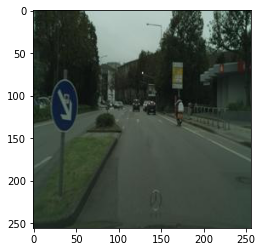

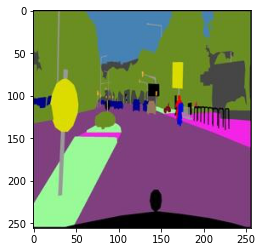

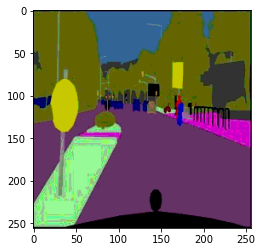

In [13]:
plt.imshow(x_data[50])
plt.show()
plt.imshow(y_data[50])
plt.show()
plt.imshow(y_n[50])
plt.show()


In [14]:
# спользуемые цвета
arr_col = n.copy()

In [15]:
num_classes = len(arr_col)
num_classes

163

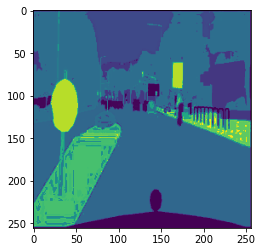

In [16]:
cat_yi,ind_yi,h = Color2index(y_n[50],arr_col)
plt.imshow(ind_yi)
plt.show()  


In [17]:
y_n_ohe = []

for i in y_n:
    y_cat,_,_ = Color2index(i,arr_col)
    y_n_ohe.append(y_cat)

y_n_ohe = np.array(y_n_ohe)

In [18]:
y_n_ohe.shape

(100, 256, 256, 163)

In [19]:
N = 80
yTrain = y_n_ohe[:N,:,:,:]
xTrain = x_data[:N,:,:,:]

yTest = y_n_ohe[N:,:,:,:]
xTest = x_data[N:,:,:,:]

In [20]:
xTrain.shape,yTrain.shape

((80, 256, 256, 3), (80, 256, 256, 163))

**Unet**

In [21]:
result = pd.DataFrame()
hist={}

Попробуем упрощенный вариант

In [22]:
img_input = Input(xTrain.shape[1:]) #256*256

# Block 1
y = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(y)
y = BatchNormalization()(y)

# запомним тензор для перенос
block_1_out = Activation('relu')(y)

y = MaxPooling2D()(block_1_out) # 128x128


# Block 2
y = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(y)
y = BatchNormalization()(y)

# запомним тензор для переноса
block_2_out = Activation('relu')(y)

y = MaxPooling2D()(block_2_out) # 64x64


# Block 3
y = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(y)
y = BatchNormalization()(y)

# запомним тензор для переноса
block_3_out = Activation('relu')(y)

y = MaxPooling2D()(block_3_out) #32x32


# Block 4
y = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(y)
y = BatchNormalization()(y)
# запомним тензор для переноса
block_4_out = Activation('relu')(y)

y = MaxPooling2D()(block_4_out) #16x16


# # Block 5
# y = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same', name='block5_conv3')(y)


# block_5_out = Activation('relu')(y)

# y = MaxPooling2D()(block_5_out) #8x8


# # Block 6
# y = Conv2D(1024, (3, 3), padding='same', name='block6_conv1')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same', name='block6_conv2')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same', name='block6_conv3')(y)
# y = BatchNormalization()(y)

# block_6_out = Activation('relu')(y)

# y = MaxPooling2D()(block_6_out) #4x4



# # UP 6
# y = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(y) #8*8
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = concatenate([y, block_6_out])
# y = Conv2D(1024, (3, 3), padding='same')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same')(y)
# y = BatchNormalization()(y)
# Activation('relu')(y)


# # UP 5
# y = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(y) #16x16
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# # добавили перенос из понижаюшего плеча
# y = concatenate([y, block_5_out])
# y = Conv2D(1024, (3, 3), padding='same')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)



# UP 4
y = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(y) # 32x32
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_4_out])
y = Conv2D(512, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(512, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

# UP 3
y = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(y) # 64x64
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_3_out])
y = Conv2D(256, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(256, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# UP 2
y = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(y) # 128x128
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_2_out])
y = Conv2D(128, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(128, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# UP 1
y = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(y) # 2566*256
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_1_out])
y = Conv2D(64, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(64, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# слой классификатор
y = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(y)

model_clas_small = Model(img_input, y,name = 'model_clas_small')
model_clas_small.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model_clas_small.summary()

Model: "model_clas_small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
___________________________________________________________________________________

In [23]:
hist['model_clas_small'] = model_clas_small.fit(xTrain, yTrain, epochs=30, batch_size=1, validation_data=(xTest, yTest))
result.loc['model_clas_small','val_dice_coef'] = hist['model_clas_small'].history['val_dice_coef'][-1]

Epoch 1/30
80/80 [==============================] - 18s 150ms/step - loss: 1.9064 - dice_coef: 0.3873 - val_loss: 3.1603 - val_dice_coef: 0.1770
Epoch 2/30
80/80 [==============================] - 12s 144ms/step - loss: 1.4215 - dice_coef: 0.4990 - val_loss: 5.6301 - val_dice_coef: 0.3126
Epoch 3/30
80/80 [==============================] - 11s 144ms/step - loss: 1.3473 - dice_coef: 0.5174 - val_loss: 5.5543 - val_dice_coef: 0.1499
Epoch 4/30
80/80 [==============================] - 11s 143ms/step - loss: 1.2706 - dice_coef: 0.5452 - val_loss: 6.1289 - val_dice_coef: 0.0831
Epoch 5/30
80/80 [==============================] - 11s 143ms/step - loss: 1.2242 - dice_coef: 0.5512 - val_loss: 7.7123 - val_dice_coef: 0.1122
Epoch 6/30
80/80 [==============================] - 11s 143ms/step - loss: 1.1933 - dice_coef: 0.5710 - val_loss: 5.5259 - val_dice_coef: 0.3242
Epoch 7/30
80/80 [==============================] - 11s 143ms/step - loss: 1.1746 - dice_coef: 0.5719 - val_loss: 1.9384 - val_dic

Возмем сеть больше

In [23]:
img_input = Input(xTrain.shape[1:]) #256*256

# Block 1
y = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(y)
y = BatchNormalization()(y)

# запомним тензор для перенос
block_1_out = Activation('relu')(y)

y = MaxPooling2D()(block_1_out) # 128x128


# Block 2
y = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(y)
y = BatchNormalization()(y)

# запомним тензор для переноса
block_2_out = Activation('relu')(y)

y = MaxPooling2D()(block_2_out) # 64x64


# Block 3
y = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(y)
y = BatchNormalization()(y)

# запомним тензор для переноса
block_3_out = Activation('relu')(y)

y = MaxPooling2D()(block_3_out) #32x32


# Block 4
y = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(y)
y = BatchNormalization()(y)
# запомним тензор для переноса
block_4_out = Activation('relu')(y)

y = MaxPooling2D()(block_4_out) #16x16


# Block 5
y = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same', name='block5_conv3')(y)


block_5_out = Activation('relu')(y)

y = MaxPooling2D()(block_5_out) #8x8


# Block 6
y = Conv2D(1024, (3, 3), padding='same', name='block6_conv1')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same', name='block6_conv2')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same', name='block6_conv3')(y)
y = BatchNormalization()(y)

block_6_out = Activation('relu')(y)

y = MaxPooling2D()(block_6_out) #4x4



# UP 6
y = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(y) #8*8
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = concatenate([y, block_6_out])
y = Conv2D(1024, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
Activation('relu')(y)


# UP 5
y = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(y) #16x16
y = BatchNormalization()(y)
y =Activation('relu')(y)
# добавили перенос из понижаюшего плеча
y = concatenate([y, block_5_out])
y = Conv2D(1024, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)



# UP 4
y = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(y) # 32x32
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_4_out])
y = Conv2D(512, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(512, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

# UP 3
y = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(y) # 64x64
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_3_out])
y = Conv2D(256, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(256, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# UP 2
y = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(y) # 128x128
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_2_out])
y = Conv2D(128, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(128, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# UP 1
y = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(y) # 2566*256
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_1_out])
y = Conv2D(64, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(64, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# слой классификатор
y = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(y)

model_class_big = Model(img_input, y,name = 'model_class_big')
model_class_big.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model_class_big.summary()

Model: "model_class_big"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 256, 256, 64) 0           batch_normalization_22[0][0]     
____________________________________________________________________________________

In [25]:
hist['model_class_big'] = model_class_big.fit(xTrain, yTrain, epochs=30, batch_size=1, validation_data=(xTest, yTest))
result.loc['model_class_big','val_dice_coef'] = hist['model_class_big'].history['val_dice_coef'][-1]

Epoch 1/30
80/80 [==============================] - 33s 374ms/step - loss: 1.8661 - dice_coef: 0.3863 - val_loss: 5.4263 - val_dice_coef: 0.1778
Epoch 2/30
80/80 [==============================] - 29s 359ms/step - loss: 1.4180 - dice_coef: 0.4939 - val_loss: 5.8349 - val_dice_coef: 0.3351
Epoch 3/30
80/80 [==============================] - 29s 362ms/step - loss: 1.3118 - dice_coef: 0.5294 - val_loss: 7.8327 - val_dice_coef: 0.3131
Epoch 4/30
80/80 [==============================] - 29s 363ms/step - loss: 1.2610 - dice_coef: 0.5423 - val_loss: 12.1184 - val_dice_coef: 0.0575
Epoch 5/30
80/80 [==============================] - 29s 364ms/step - loss: 1.2155 - dice_coef: 0.5556 - val_loss: 11.3287 - val_dice_coef: 0.0664
Epoch 6/30
80/80 [==============================] - 29s 363ms/step - loss: 1.1623 - dice_coef: 0.5776 - val_loss: 6.4714 - val_dice_coef: 0.1052
Epoch 7/30
80/80 [==============================] - 29s 363ms/step - loss: 1.1422 - dice_coef: 0.5868 - val_loss: 3.7731 - val_d

Изменим немного сеть

In [24]:
img_input = Input(xTrain.shape[1:]) #256*256

# Block 1
y = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(y)
y = BatchNormalization()(y)

# запомним тензор для перенос
block_1_out = Activation('relu')(y)

y = MaxPooling2D()(block_1_out) # 128x128


# Block 2
y = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(y)
y = BatchNormalization()(y)

# запомним тензор для переноса
block_2_out = Activation('relu')(y)

y = MaxPooling2D()(block_2_out) # 64x64


# Block 3
y = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(y)
y = BatchNormalization()(y)

# запомним тензор для переноса
block_3_out = Activation('relu')(y)

y = MaxPooling2D()(block_3_out) #32x32


# Block 4
y = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(y)
y = BatchNormalization()(y)
# запомним тензор для переноса
block_4_out = Activation('relu')(y)

y = MaxPooling2D()(block_4_out) #16x16


# # Block 5
# y = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same', name='block5_conv3')(y)


# block_5_out = Activation('relu')(y)

# y = MaxPooling2D()(block_5_out) #8x8


# # Block 6
# y = Conv2D(1024, (3, 3), padding='same', name='block6_conv1')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same', name='block6_conv2')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same', name='block6_conv3')(y)
# y = BatchNormalization()(y)

# block_6_out = Activation('relu')(y)

# y = MaxPooling2D()(block_6_out) #4x4


# # UP 6
# y = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(y) #8*8
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = concatenate([y, block_6_out])
# y = Conv2D(1024, (3, 3), padding='same')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same')(y)
# y = BatchNormalization()(y)
# Activation('relu')(y)


# # UP 5
# y = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(y) #16x16
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# # добавили перенос из понижаюшего плеча
# y = concatenate([y, block_5_out])
# y = Conv2D(1024, (3, 3), padding='same')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)
# y = Conv2D(1024, (3, 3), padding='same')(y)
# y = BatchNormalization()(y)
# y =Activation('relu')(y)



# UP 4
y = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(y) # 32x32
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_4_out])
y = Conv2D(512, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(512, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

# UP 3
y = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(y) # 64x64
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_3_out])
y = Conv2D(256, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(256, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# UP 2
y = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(y) # 128x128
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_2_out])
y = Conv2D(128, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(128, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# UP 1
y = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(y) # 2566*256
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_1_out])
y = Conv2D(64, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(64, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# слой классификатор
y = Conv2D(num_classes, (3, 3), activation='relu', padding='same')(y)
# y = Flatten()(y)
y= Dense(256,activation = 'relu')(y)
y= Dense(256,activation = 'relu')(y)
y= Dense(num_classes,activation = 'softmax')(y)

model_other_small = Model(img_input, y,name = 'model_other_small')
model_other_small.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model_other_small.summary()

Model: "model_other_small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 256, 256, 64) 0           batch_normalization_55[0][0]     
__________________________________________________________________________________

In [27]:
hist['model_other_small'] = model_other_small.fit(xTrain, yTrain, epochs=30, batch_size=1, validation_data=(xTest, yTest))
result.loc['model_other_small','val_dice_coef'] = hist['model_other_small'] .history['val_dice_coef'][-1]

Epoch 1/30
80/80 [==============================] - 17s 187ms/step - loss: 2.0449 - dice_coef: 0.3734 - val_loss: 3.2475 - val_dice_coef: 0.1485
Epoch 2/30
80/80 [==============================] - 14s 180ms/step - loss: 1.5174 - dice_coef: 0.4698 - val_loss: 10.0592 - val_dice_coef: 0.3197
Epoch 3/30
80/80 [==============================] - 14s 179ms/step - loss: 1.4256 - dice_coef: 0.5041 - val_loss: 5.2752 - val_dice_coef: 0.2827
Epoch 4/30
80/80 [==============================] - 14s 179ms/step - loss: 1.4272 - dice_coef: 0.5011 - val_loss: 4.8426 - val_dice_coef: 0.3193
Epoch 5/30
80/80 [==============================] - 14s 180ms/step - loss: 1.3620 - dice_coef: 0.5128 - val_loss: 4.4112 - val_dice_coef: 0.3173
Epoch 6/30
80/80 [==============================] - 14s 179ms/step - loss: 1.3105 - dice_coef: 0.5371 - val_loss: 4.2551 - val_dice_coef: 0.3434
Epoch 7/30
80/80 [==============================] - 14s 179ms/step - loss: 1.2502 - dice_coef: 0.5547 - val_loss: 2.2063 - val_di

Увеличим альтернативную сеть

In [25]:
img_input = Input(xTrain.shape[1:]) #256*256

# Block 1
y = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(y)
y = BatchNormalization()(y)

# запомним тензор для перенос
block_1_out = Activation('relu')(y)

y = MaxPooling2D()(block_1_out) # 128x128


# Block 2
y = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(y)
y = BatchNormalization()(y)

# запомним тензор для переноса
block_2_out = Activation('relu')(y)

y = MaxPooling2D()(block_2_out) # 64x64


# Block 3
y = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(y)
y = BatchNormalization()(y)

# запомним тензор для переноса
block_3_out = Activation('relu')(y)

y = MaxPooling2D()(block_3_out) #32x32


# Block 4
y = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(y)
y = BatchNormalization()(y)
# запомним тензор для переноса
block_4_out = Activation('relu')(y)

y = MaxPooling2D()(block_4_out) #16x16


# Block 5
y = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same', name='block5_conv3')(y)


block_5_out = Activation('relu')(y)

y = MaxPooling2D()(block_5_out) #8x8


# Block 6
y = Conv2D(1024, (3, 3), padding='same', name='block6_conv1')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same', name='block6_conv2')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same', name='block6_conv3')(y)
y = BatchNormalization()(y)

block_6_out = Activation('relu')(y)

y = MaxPooling2D()(block_6_out) #4x4


# UP 6
y = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(y) #8*8
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = concatenate([y, block_6_out])
y = Conv2D(1024, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
Activation('relu')(y)


# UP 5
y = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(y) #16x16
y = BatchNormalization()(y)
y =Activation('relu')(y)
# добавили перенос из понижаюшего плеча
y = concatenate([y, block_5_out])
y = Conv2D(1024, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(1024, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)



# UP 4
y = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(y) # 32x32
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_4_out])
y = Conv2D(512, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(512, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

# UP 3
y = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(y) # 64x64
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_3_out])
y = Conv2D(256, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(256, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# UP 2
y = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(y) # 128x128
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_2_out])
y = Conv2D(128, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(128, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# UP 1
y = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(y) # 2566*256
y = BatchNormalization()(y)
y =Activation('relu')(y)

# добавили перенос из понижаюшего плеча
y = concatenate([y, block_1_out])
y = Conv2D(64, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)

y = Conv2D(64, (3, 3), padding='same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)


# слой классификатор
y = Conv2D(num_classes, (3, 3), activation='relu', padding='same')(y)
# y = Flatten()(y)
y= Dense(256,activation = 'relu')(y)
y= Dense(256,activation = 'relu')(y)
y= Dense(num_classes,activation = 'softmax')(y)

model_other_big = Model(img_input, y,name = 'model_other_big')
model_other_big.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model_other_big.summary()

Model: "model_other_big"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_78 (Activation)      (None, 256, 256, 64) 0           batch_normalization_77[0][0]     
____________________________________________________________________________________

In [29]:
hist['model_other_big']  = model_other_small.fit(xTrain, yTrain, epochs=30, batch_size=1, validation_data=(xTest, yTest))
result.loc['model_other_big','val_dice_coef'] = hist['model_other_big'].history['val_dice_coef'][-1]

Epoch 1/30
80/80 [==============================] - 15s 183ms/step - loss: 0.8765 - dice_coef: 0.6892 - val_loss: 1.6063 - val_dice_coef: 0.5061
Epoch 2/30
80/80 [==============================] - 14s 179ms/step - loss: 0.8737 - dice_coef: 0.6862 - val_loss: 1.2207 - val_dice_coef: 0.6410
Epoch 3/30
80/80 [==============================] - 14s 179ms/step - loss: 0.8355 - dice_coef: 0.7030 - val_loss: 1.2374 - val_dice_coef: 0.6293
Epoch 4/30
80/80 [==============================] - 14s 179ms/step - loss: 0.8264 - dice_coef: 0.7092 - val_loss: 1.3217 - val_dice_coef: 0.5606
Epoch 5/30
80/80 [==============================] - 14s 179ms/step - loss: 0.8589 - dice_coef: 0.6947 - val_loss: 1.4814 - val_dice_coef: 0.5789
Epoch 6/30
80/80 [==============================] - 14s 179ms/step - loss: 0.8483 - dice_coef: 0.6971 - val_loss: 1.3478 - val_dice_coef: 0.6287
Epoch 7/30
80/80 [==============================] - 14s 179ms/step - loss: 0.8109 - dice_coef: 0.7130 - val_loss: 1.3805 - val_dic

In [30]:
# Результаты моделей:
result.sort_values('val_dice_coef',ascending=False)    

,val_dice_coef
model_class_big,0.605419
model_other_small,0.554386
model_other_big,0.505460
model_clas_small,0.504900


Посмотрим на стабильность

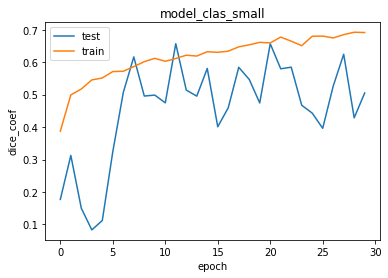

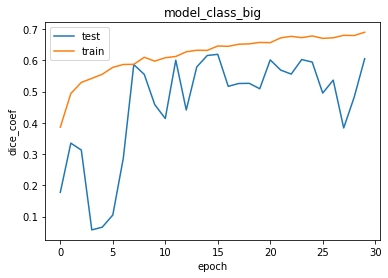

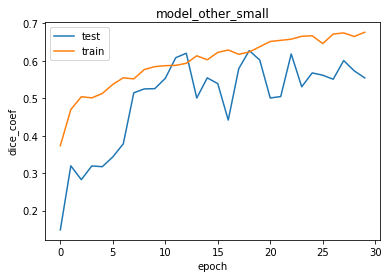

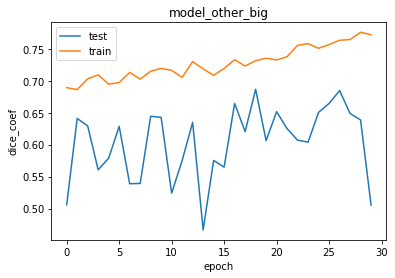

In [31]:
for n,h in hist.items(): 
    plt.plot(h.history['val_dice_coef'],label = 'test')
    plt.plot(h.history['dice_coef'],label='train')
    plt.legend()
    plt.title(n)
    plt.xlabel('epoch')
    plt.ylabel('dice_coef')
    plt.show()

Лучшая модель на мой взгляд:
Трудно сказать, нет стабильной модели
Пусть будет model_other_big	

Попоробуем ее несколько раз потестировать

In [26]:
model = model_other_big
ww = model.get_weights() 
start = time.time()
res=[]
res_tr=[]
for _ in range(10):
    model.set_weights(ww)
    hh = model.fit(x=xTrain,y=yTrain, epochs=20,\
                   batch_size=1, validation_data=(xTest, yTest), verbose=0)
    res.append(hh.history['val_dice_coef'][-1])
    res_tr.append(hh.history['dice_coef'][-1])
res = np.array(res)

d={'epochs':epochs,
    'res_max' : res.max(),
    'res_min' : res.min(),
    'res_mean' : res.mean(),
    'res_std' : res.std(),
   'batch_size':batch_size,
   'res_train_mean':np.array(res_tr).mean(),
   'time_iter': (time.time() - start)/num_iter
}   
print(d)

NameError: name 'epochs' is not defined

In [31]:
epochs = 20
batch_size=1
d={'epochs':epochs,
    'res_max' : res.max(),
    'res_min' : res.min(),
    'res_mean' : res.mean(),
    'res_std' : res.std(),
   'batch_size':batch_size,
   'res_train_mean':np.array(res_tr).mean(),

}   
pprint(d)

{'batch_size': 1,
 'epochs': 20,
 'res_max': 0.6065874099731445,
 'res_mean': 0.5615093052387238,
 'res_min': 0.5363512635231018,
 'res_std': 0.025462290326183714,
 'res_train_mean': 0.6220155358314514}


In [32]:
pred = model.predict(xTest[:5])
print(pred.shape)

(5, 256, 256, 163)


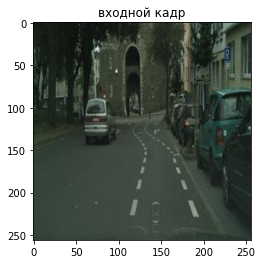

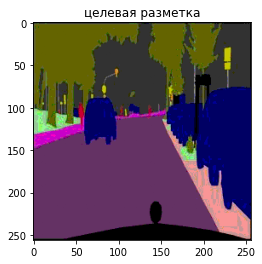

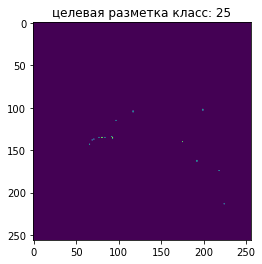

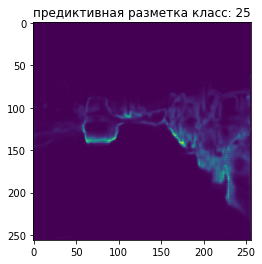

In [36]:
n = 1
class_ =25
plt.imshow(x_data[N+n])
plt.title('входной кадр')
plt.show()
plt.imshow(y_n[N+n])
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

соберем предикт в обычный вид

In [38]:
arr_col.shape

(163, 3)

In [39]:
pred.shape

(5, 256, 256, 163)

In [40]:
predict = np.zeros(pred.shape[:3]+(3,))

In [41]:
predict.shape

(5, 256, 256, 3)

In [48]:
%%time
for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
        for k in range(pred.shape[2]):
            u= np.argmax(pred[i,j,k])
            predict[i,j,k] = arr_col[u]

Wall time: 841 ms


Картинка


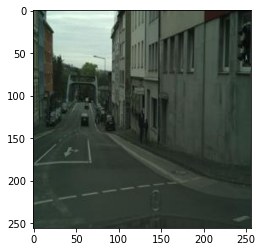

Разметка


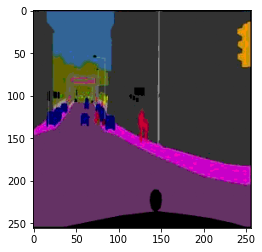

Предсказание разметки


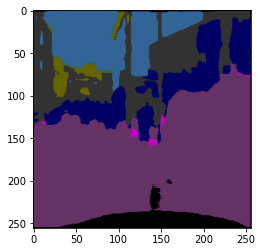

Картинка


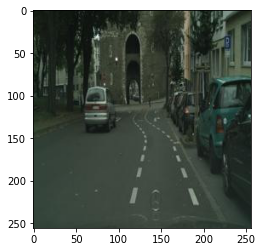

Разметка


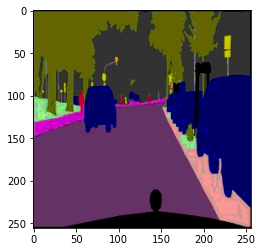

Предсказание разметки


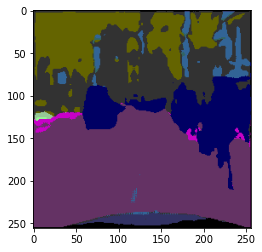

Картинка


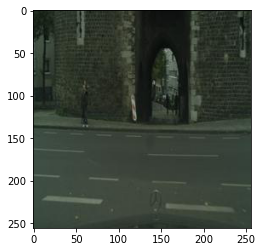

Разметка


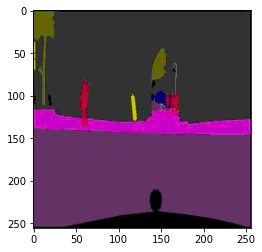

Предсказание разметки


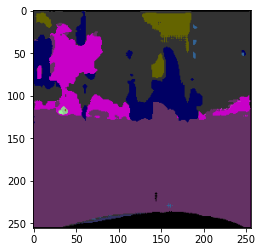

Картинка


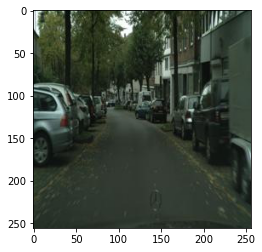

Разметка


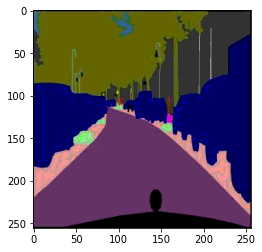

Предсказание разметки


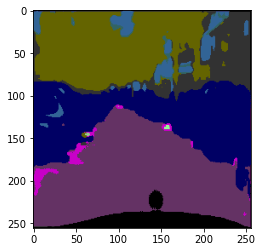

Картинка


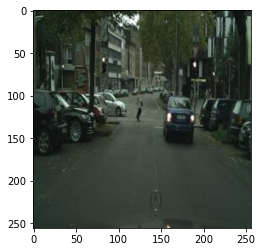

Разметка


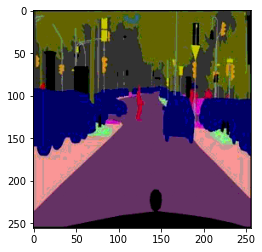

Предсказание разметки


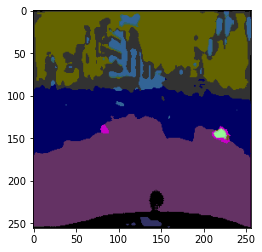

In [58]:
for i in range(5):
    print('Картинка')
    plt.imshow(xTest[i])
    plt.show()
    print('Разметка')
    plt.imshow(y_n[N+i])
    plt.show()
    print('Предсказание разметки')
    plt.imshow(predict[i])
    plt.show()
    print('='*40)

(20, 256, 256, 163)